In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import recall_score
import numpy as np
import random

# Data loading from folders
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.99, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

In [2]:
import os

def count_files_in_folders(start_path):
    """
    Counts the number of files in each folder and its subfolders
    within a given starting path.

    Args:
        start_path (str): The root directory to start counting from.

    Returns:
        dict: A dictionary where keys are folder paths and values are
              the count of files within that folder (excluding files in subfolders).
    """
    file_counts = {}
    for root, dirs, files in os.walk(start_path):
        # Count files directly within the current 'root' directory
        file_counts[root] = len(files)
    return file_counts

# Example usage:
directory_to_scan = "/path/to/your/directory"  # Replace with your desired path
counts = count_files_in_folders(directory_to_scan)

for folder, count in counts.items():
    print(f"Folder: {folder}, Files: {count}")

In [4]:
count_files_in_folders('skin_cancer_test')

{'skin_cancer_test': 0,
 'skin_cancer_test/benign': 110,
 'skin_cancer_test/malignant': 90}

In [3]:
count_files_in_folders('skin_cancer_train')

{'skin_cancer_train': 0,
 'skin_cancer_train/benign': 305,
 'skin_cancer_train/malignant': 294}

In [6]:
count_files_in_folders('skin_cancer_val')

{'skin_cancer_val': 0,
 'skin_cancer_val/benign': 110,
 'skin_cancer_val/malignant': 90}

In [7]:
9705 - 294

9411

In [8]:
9706 + 294

10000

In [9]:
class SkinCancerClassification(nn.Module):
    def __init__(self):
        super(SkinCancerClassification, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # self.pool3 = nn.MaxPool2d(2, 2)

        # self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16384, 64)
        self.fc2 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dp = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        # x = self.pool3(self.relu(self.conv3(x)))
        # x = self.pool4(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dp(x)
        x = self.fc2(x)
        return x
# mat1 and mat2 shapes cannot be multiplied (32x32768 and 16384x64)

In [10]:
from pathlib import Path

In [11]:
files_to_delete_count = 800
folder = Path('skin_cancer_val/benign')

files = [f for f in folder.iterdir() if f.is_file()]
files_to_delete = random.sample(files, files_to_delete_count)

ValueError: Sample larger than population or is negative

In [36]:
for file_path in files_to_delete:
    # print(f"  - {file_path.name}")
    file_path.unlink()  


In [19]:
def get_data_loaders(train_dir='skin_cancer_train', val_dir='skin_cancer_val', test_dir='skin_cancer_test'):

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)

    val_dataset = datasets.ImageFolder(val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Classes: {train_dataset.classes}")
    
    return train_loader, val_loader, test_loader

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [21]:
train_dir='skin_cancer_train'
val_dir='skin_cancer_val'
test_dir='skin_cancer_test'

train_loader, val_loader, test_loader = get_data_loaders(train_dir, val_dir, test_dir)


Train samples: 599
Validation samples: 200
Test samples: 200
Classes: ['benign', 'malignant']


In [22]:
model = SkinCancerClassification().to(device)
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
train_losses = []
val_losses = []
train_recalls = []
val_recalls = []

In [24]:

for epoch in range(100):

    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.float().to(device)  
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1)) 
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        with torch.no_grad():
            preds = torch.sigmoid(outputs) > 0.5
            train_preds.extend(preds.cpu().numpy().flatten())
            train_targets.extend(batch_y.cpu().numpy())
    

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.float().to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            val_loss += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(batch_y.cpu().numpy())
    
    recall = recall_score(all_targets, all_preds)
    
    train_recall = recall_score(train_targets, train_preds)
    val_recall = recall_score(all_targets, all_preds)
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)
    
    print(f"Epoch {epoch + 1}/100:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Recall: {recall:.4f}")
    print("-" * 30)


Epoch 1/100:
  Train Loss: 0.0614
  Val Loss: 0.0425
  Recall: 0.3889
------------------------------
Epoch 2/100:
  Train Loss: 0.0422
  Val Loss: 0.0393
  Recall: 0.8778
------------------------------
Epoch 3/100:
  Train Loss: 0.0397
  Val Loss: 0.0372
  Recall: 0.9444
------------------------------
Epoch 4/100:
  Train Loss: 0.0379
  Val Loss: 0.0348
  Recall: 0.8000
------------------------------
Epoch 5/100:
  Train Loss: 0.0370
  Val Loss: 0.0304
  Recall: 0.8667
------------------------------
Epoch 6/100:
  Train Loss: 0.0361
  Val Loss: 0.0290
  Recall: 0.8889
------------------------------
Epoch 7/100:
  Train Loss: 0.0348
  Val Loss: 0.0296
  Recall: 0.7444
------------------------------
Epoch 8/100:
  Train Loss: 0.0326
  Val Loss: 0.0270
  Recall: 0.7778
------------------------------
Epoch 9/100:
  Train Loss: 0.0321
  Val Loss: 0.0300
  Recall: 0.7778
------------------------------
Epoch 10/100:
  Train Loss: 0.0315
  Val Loss: 0.0249
  Recall: 0.8333
--------------------

In [25]:

def plot_learning_curves(train_losses, val_losses, train_recalls, val_recalls):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', marker='o')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', marker='s')
    ax1.set_title('Training vs Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_recalls, 'b-', label='Training Recall', marker='o')
    ax2.plot(epochs, val_recalls, 'r-', label='Validation Recall', marker='s')
    ax2.set_title('Training vs Validation Recall')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Recall')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1) 
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Training Loss: ", train_losses[-1])
    print(f"Final Validation Loss: ", val_losses[-1])
    print(f"Final Training Recall: ", train_recalls[-1])
    print(f"Final Validation Recall: ", val_recalls[-1])

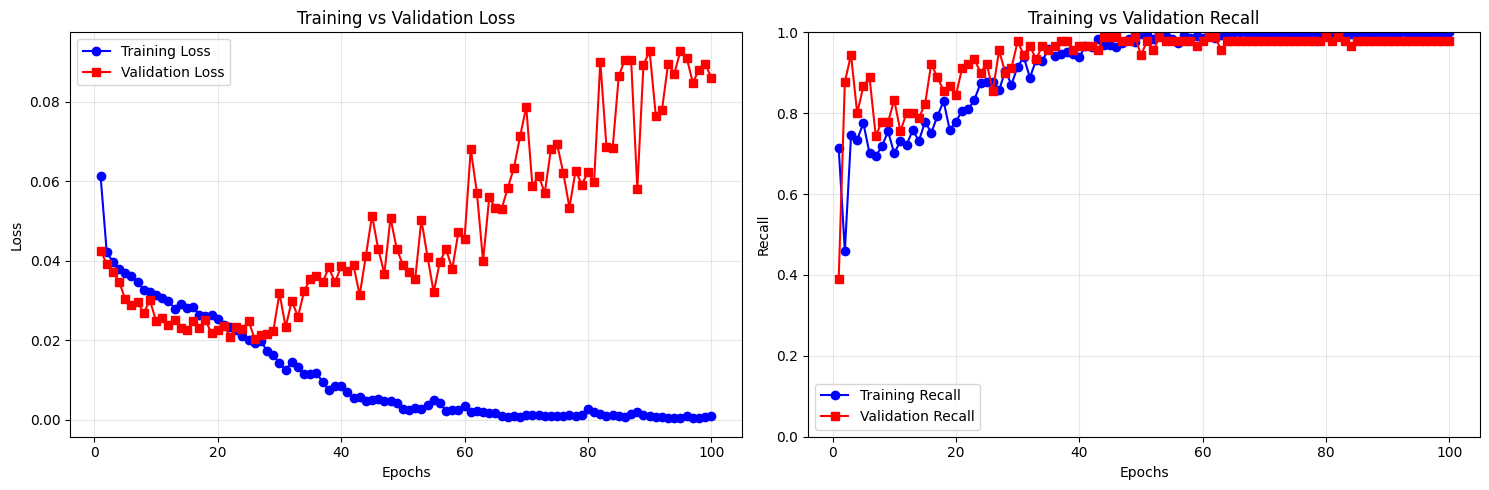


Final Training Loss:  0.0008725273785928852
Final Validation Loss:  0.08609153155287329
Final Training Recall:  1.0
Final Validation Recall:  0.9777777777777777


In [26]:
plot_learning_curves(train_losses, val_losses, train_recalls, val_recalls)

In [27]:
test_loader

In [28]:

test_loss = 0.0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.float().to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        test_loss += loss.item()
        
        # Get predictions
        preds = torch.sigmoid(outputs) > 0.3
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(batch_y.cpu().numpy())


In [29]:
# Calculate recall
recall = recall_score(all_targets, all_preds)

In [30]:
recall

0.9611111111111111

In [31]:
10000

10000

In [32]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [33]:
cm = confusion_matrix(all_targets,all_preds)

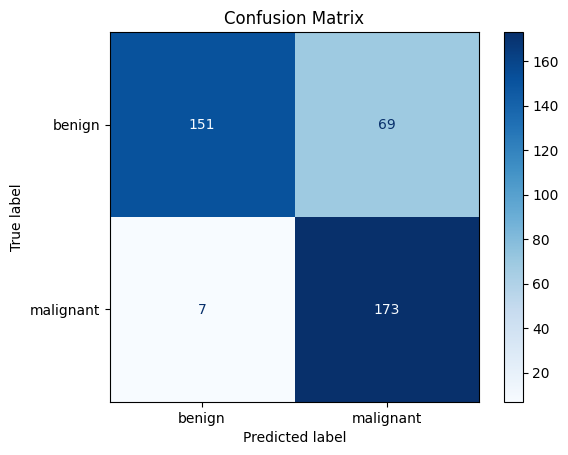

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()